# **M5 forecasting Accuracy - EDA**

The sales forecasting problem is considered to be a Multivariate Time series problem. It consists of multiple time dependent variables. Each variable will have dependency on its past values, and some other variables as well.

In general, sales in a super market can depend upon multiple factors like,
- Supermarket environmental attributes - security, cleanliness, parking space, public travel options, ambience.
- Variety of goods - different brands range, Product quality, Home delivery, Fast Customer Service.
- Product promotions - Special discounts, Combo offer, Free goods.
- Special occasions - Sports event or a religious festival, Govt or bank holidays.
- Day of the week - Wednesday could be a low sale day, sales on a Friday and weekends could be high.

Let us do an Exploratory Data Analysis on the Walmart sales dataset. Below files were listed in Kaggle.
- Day wise sales of all the SKUs, in multiple Walmart stores in three different states for 6 years (2011 to 2016) - CA, Texas, Wisconsin.
- Calendar data having details of events and festivals in those years.
- Week-wise Selling price of all the SKUs.
- Sample o/p submission format.

### **Solution Plan**
- Picking the best selling products of Texas stores. 
- Choosing those lines having good auto-correlation.
- Calendar events are considered in the training data to learn the seasonal and event based trends. Event name, Snap_TX, week number are considered for training.
- The selling price given is for CA_1 store only. The selling price is not considered in this iteration.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os

### Read the required csv files

In [2]:
sales_train_evaluation_path = r'/Users/sowmya/Learning/Kaggle/M5 Forecasting/dataset/sales_train_evaluation.csv'
calendar_path = r'/Users/sowmya/Learning/Kaggle/M5 Forecasting/dataset/calendar.csv'
calendar = pd.read_csv(calendar_path)
sales_train_evaluation_df = pd.read_csv(sales_train_evaluation_path)
sales_dates = pd.to_datetime(calendar['date'])[:1941]

### Prediction for entire range of line items is not feasible due to computation issues. Hence, selecting best selling items from the state Texas only. The items that sell atleast 50 units in a day is considered.

In [3]:
sales_subset = sales_train_evaluation_df.set_index('id')
sales_cols = sales_subset.columns
sales_subset2 = sales_subset.iloc[:, 4: 20]
sales_subset3 = sales_subset2.loc[(sales_subset2['state_id']=='TX')]
sales_subset4 = sales_subset3.iloc[:,1:]

non_zero_skus = sales_subset4.replace(0,np.nan).dropna(axis=0,how="all")
non_zeros_all = non_zero_skus.dropna()
subset_greater_50 = non_zeros_all.loc[(non_zeros_all['d_1'] > 50)]

item_list = list(subset_greater_50.index)
subset_50 = subset_greater_50.drop(subset_greater_50.columns, axis=1)

training_data_initial = pd.merge(sales_subset, subset_50, how='inner', on=['id'])

#Transpose the dataframe, to make day wise data to rows.
training_data_initial = training_data_initial.T

#Trimming the unwanted rows
training_data = training_data_initial[5:]

### List of line items considered

In [4]:
print(training_data.columns)

Index(['FOODS_3_586_TX_1_evaluation', 'FOODS_3_252_TX_2_evaluation',
       'FOODS_3_555_TX_2_evaluation', 'FOODS_3_586_TX_2_evaluation',
       'FOODS_3_252_TX_3_evaluation', 'FOODS_3_318_TX_3_evaluation',
       'FOODS_3_555_TX_3_evaluation', 'FOODS_3_586_TX_3_evaluation',
       'FOODS_3_587_TX_3_evaluation'],
      dtype='object', name='id')


### **Time series line plot**
### Item-wise sales plot each day is shown 
The plot shows there are certain days when the sales is spiked up and down. This is due to the special events throughout the year. The other days the sales is a wavy pattern. 

Hence we need the event details and the weekday details present in the calendar.csv as input.

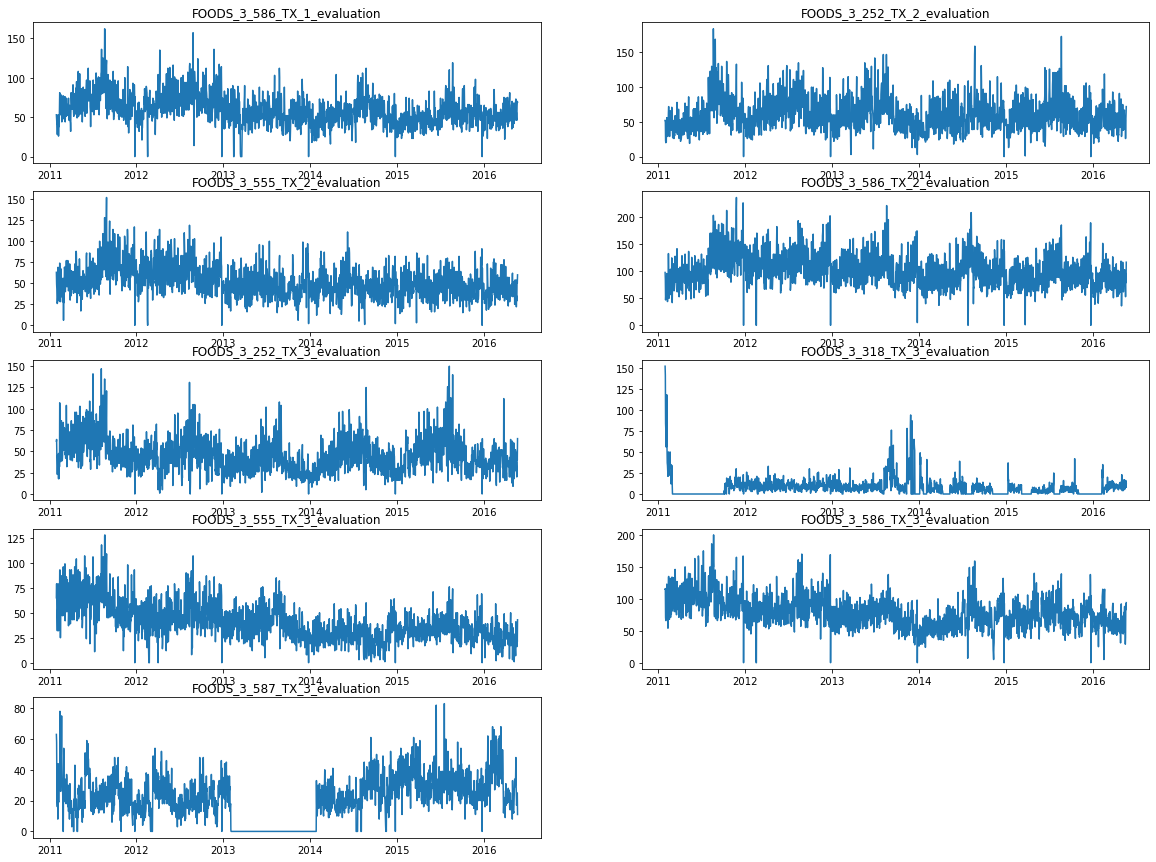

"\nplt.figure(figsize=(20,15))\nplt.subplot(521)\nplt.plot(sales_dates, training_data[training_data.columns[0]])\nplt.gca().set_title('FOODS_3_586_TX_1')\nplt.subplot(522)\nplt.plot(sales_dates, training_data[training_data.columns[1]])\nplt.gca().set_title('FOODS_3_252_TX_2')\nplt.subplot(523)\nplt.plot(sales_dates, training_data[training_data.columns[2]])\nplt.gca().set_title('FOODS_3_555_TX_2')\nplt.subplot(524)\nplt.plot(sales_dates, training_data[training_data.columns[3]])\nplt.gca().set_title('FOODS_3_586_TX_2')\nplt.subplot(525)\nplt.plot(sales_dates, training_data[training_data.columns[4]])\nplt.gca().set_title('FOODS_3_252_TX_3')\nplt.subplot(526)\nplt.plot(sales_dates, training_data[training_data.columns[5]])\nplt.gca().set_title('FOODS_3_318_TX_3')\nplt.subplot(527)\nplt.plot(sales_dates, training_data[training_data.columns[6]])\nplt.gca().set_title('FOODS_3_555_TX_3')\nplt.subplot(528)\nplt.plot(sales_dates, training_data[training_data.columns[7]])\nplt.gca().set_title('FOOD

In [75]:
plt.figure(figsize=(20,15))

a = 5
b = 2
c = 1

for i, col in enumerate(cols):
    plt.subplot(a,b,c+i)
    plt.plot(sales_dates, training_data[col])
    plt.gca().set_title(col)
    
plt.show()

### **Time series Lag plot**
### Lag plot for all the items shown below

A useful type of plot to explore the relationship between each observation and a lag of that observation is called the scatter plot.

Pandas has a built-in function for exactly this called the lag plot. It plots the observation at time t on the x-axis and the lag1 observation (t-1) on the y-axis.

If the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a positive correlation relationship.
If the points cluster along a diagonal line from the top-left to the bottom-right, it suggests a negative correlation relationship.
Either relationship is good as they can be modeled.
More points tighter in to the diagonal line suggests a stronger relationship and more spread from the line suggests a weaker relationship.

A ball in the middle or a spread across the plot suggests a weak or no relationship.

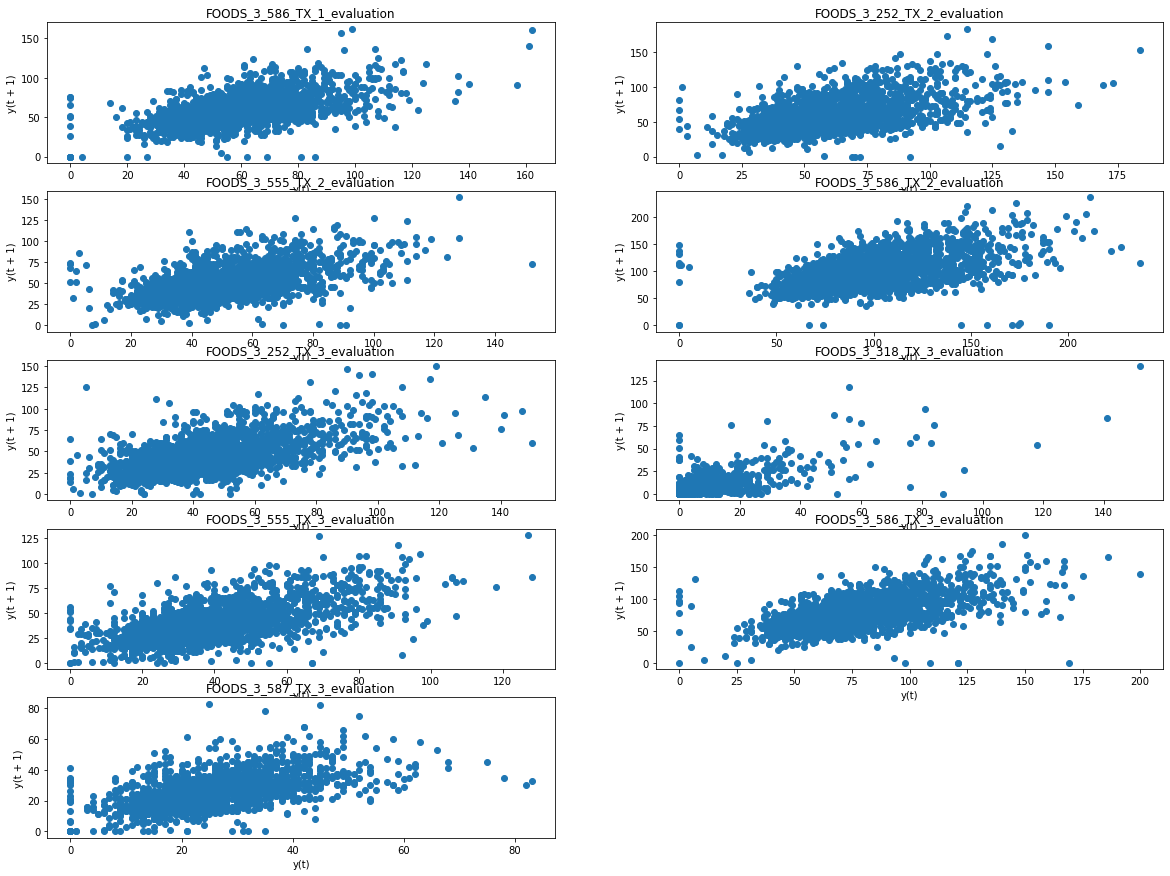

In [73]:
plt.figure(figsize=(20,15))

a = 5
b = 2
c = 1

for i, col in enumerate(cols):
    plt.subplot(a,b,c+i)
    lag_plot(training_data[col])
    plt.gca().set_title(col)
    
plt.show()

### **Time series Auto-correlation plot**

We can quantify the strength and type of relationship between observations and their lags.

In statistics, this is called correlation, and when calculated against lag values in time series, it is called autocorrelation (self-correlation).

A correlation value calculated between two groups of numbers, such as observations and their lag1 values, results in a number between -1 and 1. The sign of this number indicates a negative or positive correlation respectively. A value close to zero suggests a weak correlation, whereas a value closer to -1 or 1 indicates a strong correlation.

Correlation values, called correlation coefficients, can be calculated for each observation and different lag values. Once calculated, a plot can be created to help better understand how this relationship changes over the lag.

/Users/sowmya/opt/anaconda3/envs/p3.9/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


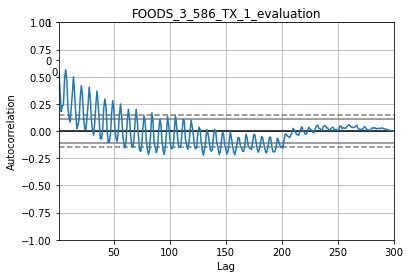

/Users/sowmya/opt/anaconda3/envs/p3.9/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


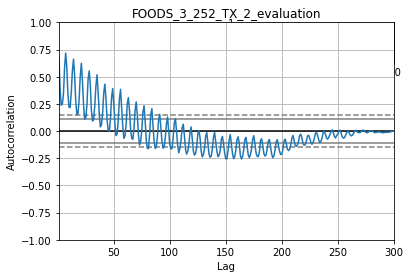

/Users/sowmya/opt/anaconda3/envs/p3.9/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


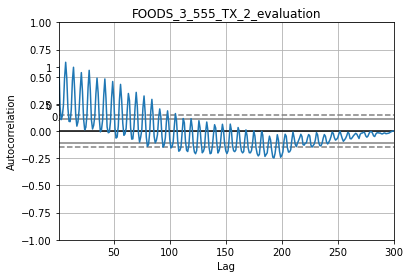

/Users/sowmya/opt/anaconda3/envs/p3.9/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


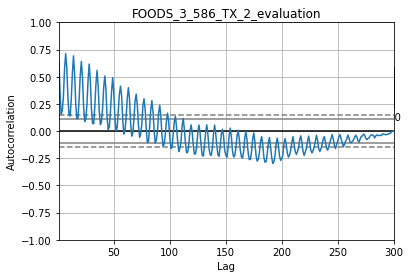

/Users/sowmya/opt/anaconda3/envs/p3.9/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


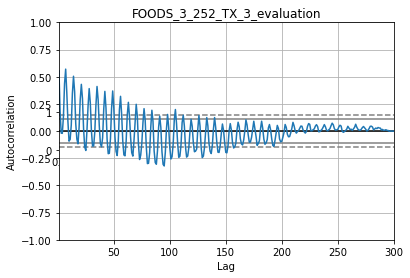

/Users/sowmya/opt/anaconda3/envs/p3.9/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


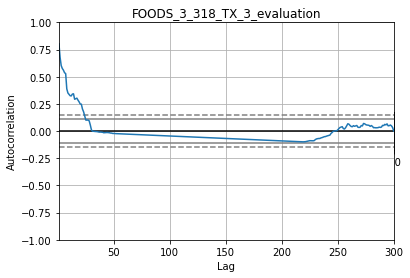

/Users/sowmya/opt/anaconda3/envs/p3.9/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


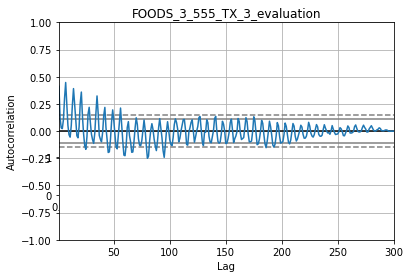

/Users/sowmya/opt/anaconda3/envs/p3.9/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


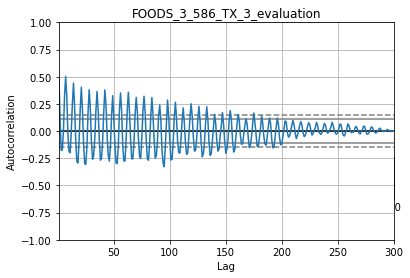

/Users/sowmya/opt/anaconda3/envs/p3.9/lib/python3.7/site-packages/pandas/plotting/_matplotlib/misc.py:411: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


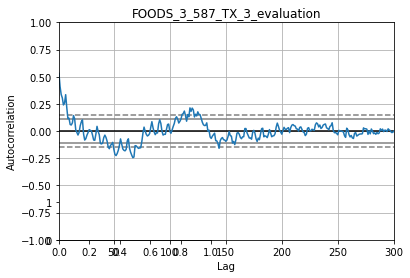

In [84]:
from pandas.plotting import autocorrelation_plot

#plt.figure(figsize=(20,15))
plt.figure()

a = 5
b = 2
c = 1

for i, col in enumerate(cols):
    plt.subplot(a,b,c+i)
    x = training_data[col][:300]
    autocorrelation_plot(x)
    plt.gca().set_title(col)
    plt.show()
    


### From the auto-correlation plot of FOODS_3_318_TX_3 and FOODS_3_587_TX_3 (6th and 9th plot), it is clear that the sales for these two items doen't show proper seaonality and correlation. Hence dropping these two items while creating the prediction model.

### **References**
https://machinelearningmastery.com/time-series-data-visualization-with-python/